In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import defaultdict


from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

sys.path.append('..')

from utils.dataset import DatasetReader
from utils.metrics import mse, psnr
from models.baseline import Baseline

In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(0)

# Get Data

In [4]:
dr = DatasetReader(dataset_path='../temp/PUC_DIR')

In [5]:
x_train, y_train, x_val, y_val, _, _ = dr.get_dataset()

In [6]:
x_train[0].shape, y_train[0].shape

((32, 32), (64, 64))

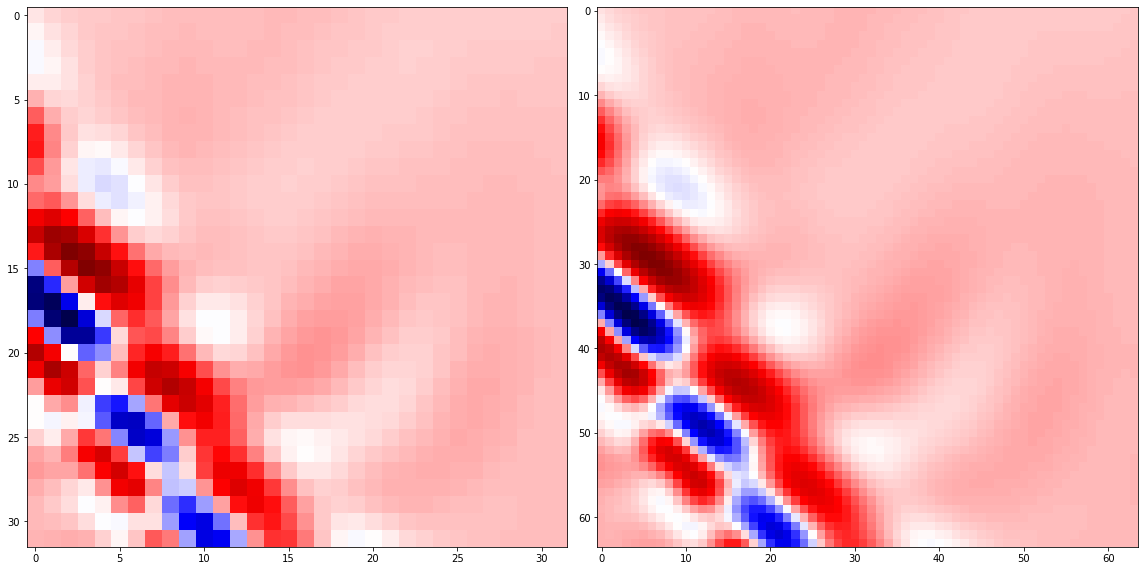

In [7]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(x_train[999], cmap='seismic')

ax[1].imshow(y_train[999], cmap='seismic')

plt.tight_layout()
plt.show()

# MLP

In [8]:
tf.keras.backend.set_floatx('float64')

class MLP(tf.keras.Model):
    def __init__(self, int_dims, original_dim=64, learning_rate=0.001, activ_hidden=tf.nn.relu, activ_out=None):
        super(MLP, self).__init__()
        
        self.resolution = original_dim
        
        self.activation_hidden_layer = activ_hidden
        self.activation_output_layer = activ_out
        
        self.hidden_layers = []

        for i in range(len(int_dims)):
            self.hidden_layers.append(tf.keras.layers.Dense(
                units=int_dims[i],
                activation=activ_hidden,
                kernel_initializer='he_uniform'))
        
        self.output_layer = tf.keras.layers.Dense(
                units=self.resolution**2,
                activation=activ_out,
                kernel_initializer='he_uniform')
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        self.loss_metric = tf.keras.metrics.MeanSquaredError()
        
        self.loss = tf.keras.losses.MeanSquaredError()
        
        self.log_metrics = defaultdict(list)
        
        self.learning_rate = learning_rate

    def call(self, input_features):
        result = tf.reshape(input_features, (-1, (self.resolution//2)**2))
        for i in range(len(self.hidden_layers)):
            result = self.hidden_layers[i](result)
        
        out = self.output_layer(result)
        
        return tf.reshape(out, (-1, self.resolution, self.resolution))

    @tf.function
    def train(self, x, y):
        with tf.GradientTape() as tape:
            predictions = self(x)
            
            loss_value = self.loss(predictions, y)
            
            self.loss_metric.update_state(predictions, y)
                        
            gradients = tape.gradient(loss_value, self.trainable_variables)
            
            gradient_variables = zip(gradients, self.trainable_variables)
            
            self.optimizer.apply_gradients(gradient_variables)
            
            return loss_value

    def make_dataset(self, x, y, x_val, y_val):
        x_train = tf.data.Dataset.from_tensor_slices(x)
        x_val = tf.data.Dataset.from_tensor_slices(x_val)
        
        y_train = tf.data.Dataset.from_tensor_slices(y)
        y_val = tf.data.Dataset.from_tensor_slices(y_val)
            
        return x_train, y_train, x_val, y_val

    def train_epochs(self, x_train, y_train, x_val, y_val, n_epochs, batch_size, SEED=42):
        x_train, y_train, x_val, y_val = self.make_dataset(x_train, y_train, x_val, y_val)
        loss = []
        for epoch in range(n_epochs):
            loss_val = []
            batches_x = x_train.batch(batch_size)
            batches_y = y_train.batch(batch_size)
            
            # Training loop
            for _x, _y in zip(batches_x, batches_y):
                self.train( _x, _y)
            
            batches_x_val = x_val.batch(batch_size)
            batches_y_val = y_val.batch(batch_size)
            
            # Validation loop
            for _x, _y in zip(batches_x, batches_y):
                loss_val.append(self.loss(self(_x), _y))

            loss_train = self.loss_metric.result().numpy()
            
            if epoch%20 == 0 or epoch == 0:
                print(f'Epoch: {epoch} Train Loss: {loss_train} Validation Loss: {np.mean(loss_val)}')
            loss.append(np.mean(loss_val))

            self.log_metrics['loss_train'].append(loss_train)
            self.log_metrics['loss_val'].append(np.mean(loss_val))

            self.loss_metric.reset_states()
       
        print(f'Epoch: {epoch} Train Loss: {loss_train} Validation Loss: {np.mean(loss_val)}')
        return pd.DataFrame(self.log_metrics)


In [9]:
model = MLP([2048])

In [10]:
_ = model(np.random.random_sample((1, 32, 32)))

model.summary()

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2099200   
_________________________________________________________________
dense_1 (Dense)              multiple                  8392704   
_________________________________________________________________
mean_squared_error (MeanSqua multiple                  2         
Total params: 10,491,906
Trainable params: 10,491,904
Non-trainable params: 2
_________________________________________________________________


## Train

In [11]:
result = model.train_epochs(x_train, y_train, x_val, y_val, 3000, 64)


If you intended to run this layer in float64, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float32 by default, call `tf.keras.backend.set_floatx('float32')`. To change just this layer, pass dtype='float32' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0 Train Loss: 0.004008355418924812 Validation Loss: 0.002160500967875123
Epoch: 20 Train Loss: 0.00038885104669306435 Validation Loss: 0.0003630861174315214
Epoch: 40 Train Loss: 0.00022265186893705285 Validation Loss: 0.00017093696806114167
Epoch: 60 Train Loss: 0.00019414666292763018 Validation Loss: 0.0001797260483726859
Epoch: 80 Train Loss: 0.00015269135647462488 Validation Loss: 0.00012751779286190867
Epoch: 100 Train Loss: 0.00011768492713652141 Validation Loss: 9.012986265588552e-05
Epoch

Epoch: 1760 Train Loss: 1.1517575630818702e-05 Validation Loss: 7.727726369921584e-06
Epoch: 1780 Train Loss: 1.451513730987194e-05 Validation Loss: 9.53259859670652e-06
Epoch: 1800 Train Loss: 1.4720040796560139e-05 Validation Loss: 9.206162758346181e-06
Epoch: 1820 Train Loss: 1.4646478128846843e-05 Validation Loss: 9.342933481093496e-06
Epoch: 1840 Train Loss: 1.4447651695069492e-05 Validation Loss: 8.853788131091278e-06
Epoch: 1860 Train Loss: 1.263629983777589e-05 Validation Loss: 9.26761276787147e-06
Epoch: 1880 Train Loss: 1.3176016756047768e-05 Validation Loss: 7.0121009230206255e-06
Epoch: 1900 Train Loss: 1.0516138681715036e-05 Validation Loss: 6.262158876779722e-06
Epoch: 1920 Train Loss: 1.575249264550542e-05 Validation Loss: 1.0831644431164023e-05
Epoch: 1940 Train Loss: 1.5293704594068834e-05 Validation Loss: 9.48360775510082e-06
Epoch: 1960 Train Loss: 1.3977931943890769e-05 Validation Loss: 7.477661711163819e-06
Epoch: 1980 Train Loss: 1.1907517817393896e-05 Validation 

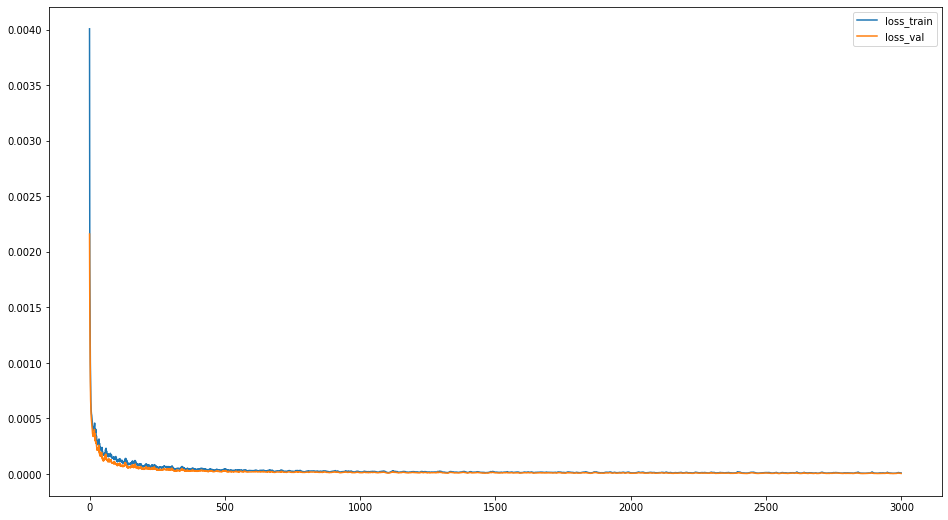

In [12]:
result.plot()

In [13]:
y = model(x_train)

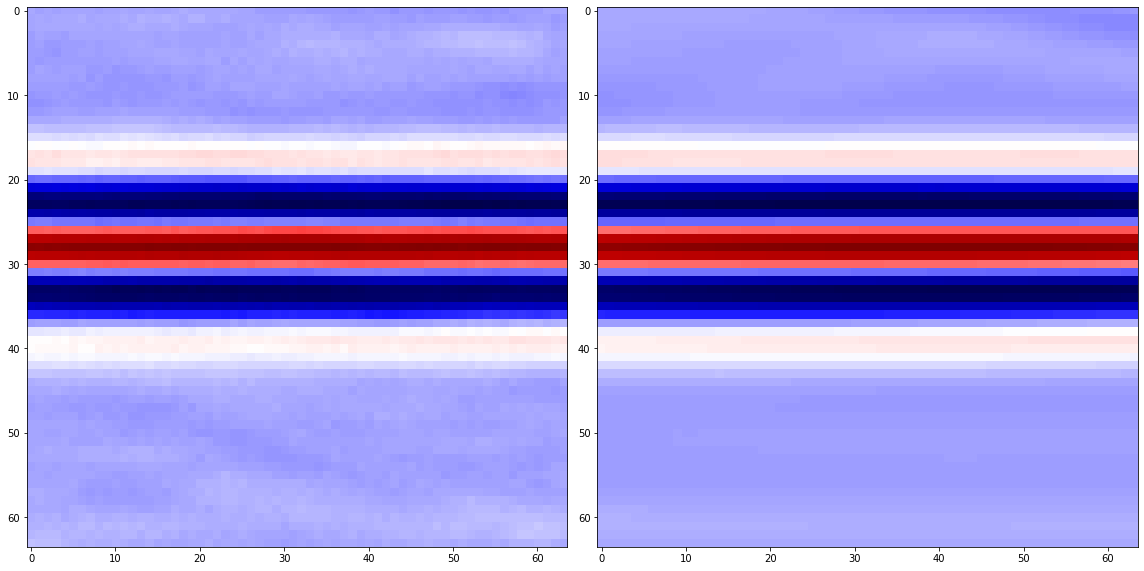

In [14]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y[1], cmap='seismic')

ax[1].imshow(y_train[1], cmap='seismic')

plt.tight_layout()
plt.show()

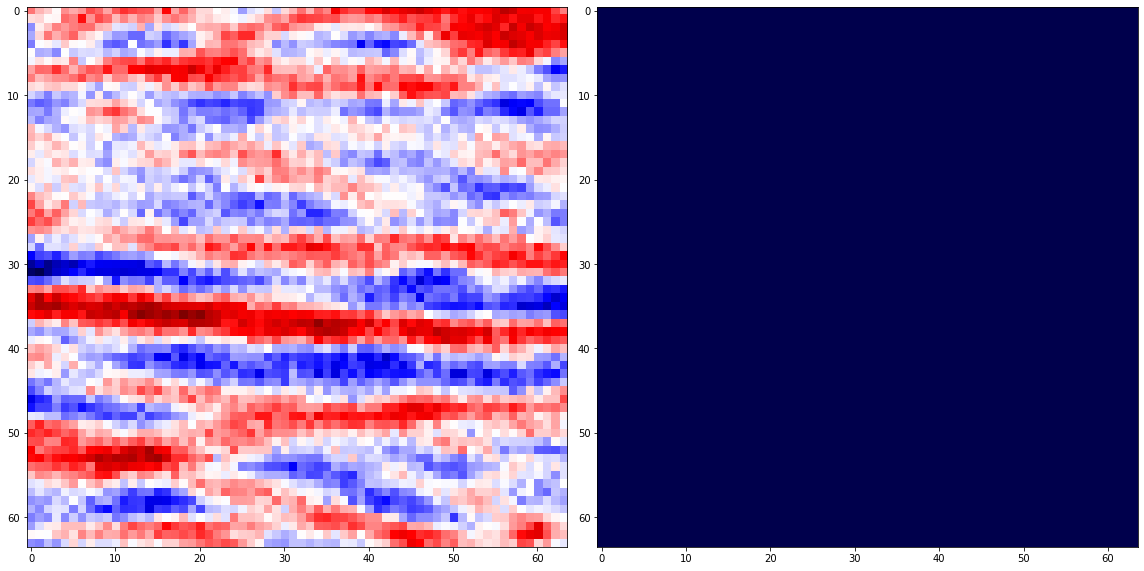

In [15]:
fig, axes = plt.subplots(ncols=2)

ax = axes.ravel()

ax[0].imshow(y[21], cmap='seismic')

ax[1].imshow(y_train[21], cmap='seismic')

plt.tight_layout()
plt.show()

In [26]:
_ = psnr(y_train, y)
_ = mse(y_train, y)

Mean PSNR 59.72909565394992
Mean MSE 4.691019780326341e-06


In [27]:
baseline = Baseline()
_ = baseline.evaluate(x_train, y_train)

Mean MSE 9.11177189525435e-05
Mean PSNR 58.821573928627124
